# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA    

import time

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('./Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('./AZDIAS_Feature_Summary.csv', delimiter=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
display(azdias.head())
display(azdias.shape)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


(891221, 85)

In [4]:
display(feat_info)
display(feat_info.shape)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


(85, 4)

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [5]:
# Store the column names out
colnames = azdias.columns

# Replace the missing value with NaN
feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].apply(lambda x: x[1:-1].split(','))

# Identify missing or unknown data values and convert them to NaNs.
for attrib, missing_values in zip(feat_info['attribute'], feat_info['missing_or_unknown']):
    if missing_values[0] != '':
        for code in missing_values:
            if code.isnumeric() or code.lstrip('-').isnumeric():
                code = int(code)
            azdias.loc[azdias[attrib] == code, attrib] = np.nan
            


In [6]:
# Due to long processing time store the parsed dataframe to new file
# azdias.to_csv('azdias_parsed.csv', sep=';', index = False)

In [7]:
# Read in replaced date again
# azdias = pd.read_csv('./azdias_parsed.csv', delimiter=';')

In [8]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [9]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
col_missing_cnt = azdias.isnull().sum()
col_missing_pct = col_missing_cnt[col_missing_cnt > 0] * 100.00 / (azdias.shape[0])

col_missing_pct

AGER_TYP                 76.955435
ALTERSKATEGORIE_GROB      0.323264
CJT_GESAMTTYP             0.544646
GEBURTSJAHR              44.020282
GFK_URLAUBERTYP           0.544646
HEALTH_TYP               12.476816
LP_LEBENSPHASE_FEIN      10.954859
LP_LEBENSPHASE_GROB      10.611509
LP_FAMILIE_FEIN           8.728699
LP_FAMILIE_GROB           8.728699
LP_STATUS_FEIN            0.544646
LP_STATUS_GROB            0.544646
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
RETOURTYP_BK_S            0.544646
SHOPPER_TYP              12.476816
SOHO_KZ                   8.247000
TITEL_KZ                 99.757636
VERS_TYP                 12.476816
ALTER_HH                 34.813699
ANZ_PERSONEN              8.247000
ANZ_TITEL                 8.247000
HH_EINKOMMEN_SCORE        2.058749
KK_KUNDENTYP             65.596749
W_KEIT_KIND_HH           16.605084
WOHNDAUER_2008            8.247000
ANZ_HAUSHALTE_AKTIV      11.176913
ANZ_HH_TITEL             10.884842
GEBAEUDETYP         

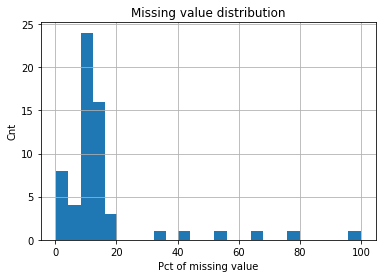

In [10]:
# Investigate patterns in the amount of missing data in each column.
col_missing_pct.sort_values(inplace=True)
plt.hist(col_missing_pct, bins = 25)

plt.xlabel('Pct of missing value')
plt.ylabel('Cnt')
plt.title('Missing value distribution')
plt.grid(True)
plt.show()

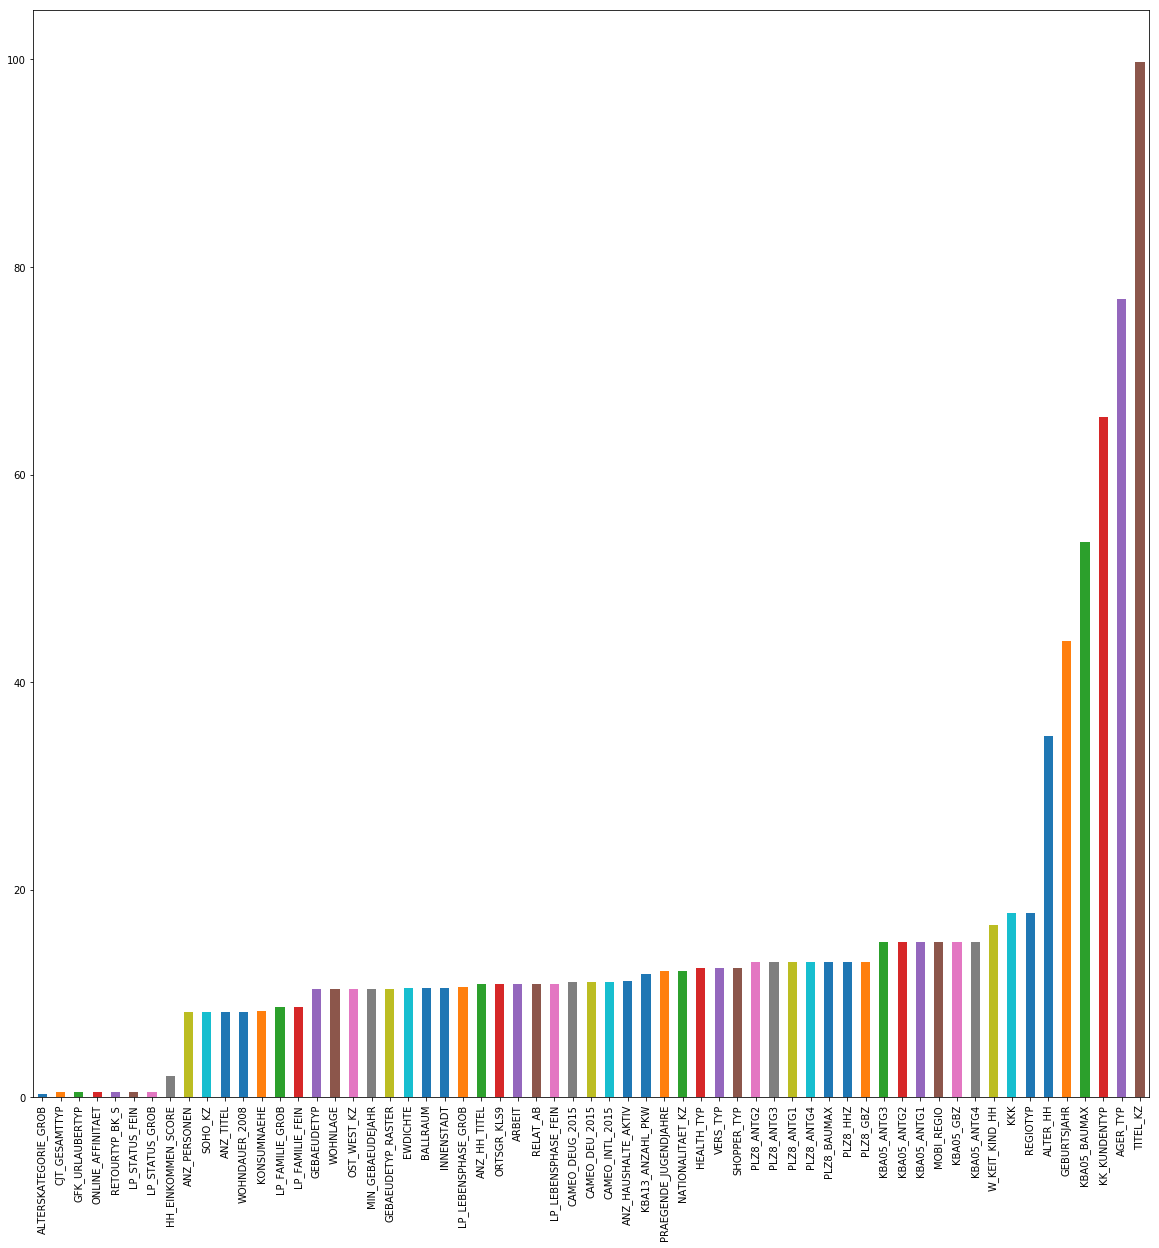

In [11]:
# Explore the detail -- check the name of outlier column
col_missing_pct.plot.bar(figsize=(20,20))

In [12]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
missing_30 = col_missing_pct[col_missing_pct > 30]
missing_30

ALTER_HH        34.813699
GEBURTSJAHR     44.020282
KBA05_BAUMAX    53.468668
KK_KUNDENTYP    65.596749
AGER_TYP        76.955435
TITEL_KZ        99.757636
dtype: float64

In [13]:
# Drop the column which has missing value more than 30%
for col_name in missing_30.index:
    azdias.drop(col_name, axis=1, inplace=True)

In [14]:
azdias.shape

(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column

There are 61 columns which has missing value among all 85 columns. Among those 61 columns, most of columns has less than 20% missing value but some outliers reaches more than 40%, 60% even 80% missing values. Since that high percentage of missing value will not be helpful for later analysis, here the columns with more than 30% missing value are removed. Removed columns include ALTER_HH, GEBURTSJAHR, KBA05_BAUMAX, KK_KUNDENTYP, AGER_TYP, TITEL_KZ.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

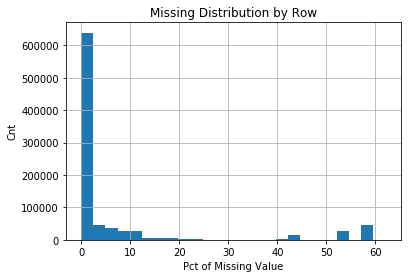

In [15]:
# How much data is missing in each row of the dataset?
row_missing_cnt = azdias.isnull().sum(axis=1)
# row_missing_pct = row_missing_cnt[row_missing_cnt > 0] / azdias.shape[1]*100.00
row_missing_pct = row_missing_cnt / azdias.shape[1]*100.00
row_missing_pct.sort_values(inplace=True)

plt.hist(row_missing_pct, bins=25)

plt.title('Missing Distribution by Row')
plt.xlabel('Pct of Missing Value')
plt.ylabel('Cnt')
plt.grid(True)

plt.show()

In [16]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
many_missing = azdias.iloc[[i for i in row_missing_pct[row_missing_pct > 30].index]].reset_index(drop=True)
few_missing = azdias.iloc[[i for i in row_missing_pct[row_missing_pct < 30].index]].reset_index(drop=True)


In [17]:
display(many_missing.shape)
display(few_missing.shape)

(93384, 79)

(797837, 79)

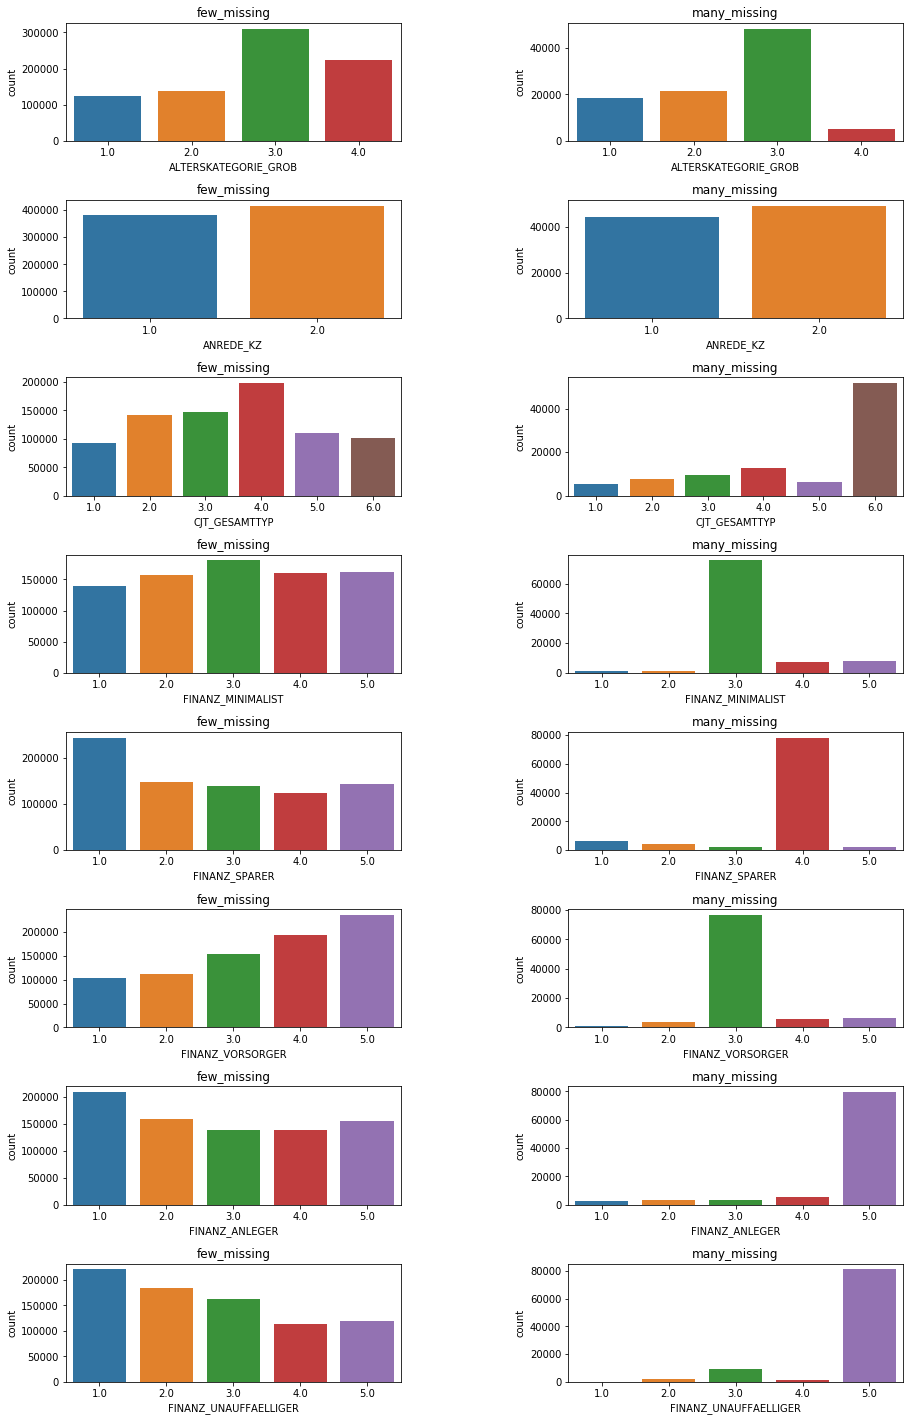

In [18]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
def plot_countplot(cols, num):
    fig, axs = plt.subplots(num, 2, figsize=(15, 25))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)
    axs = axs.ravel()
    for col in range(num):
        
        sns.countplot(few_missing[cols[col]], ax=axs[col*2])
        axs[col*2].set_title('few_missing')
        
        sns.countplot(many_missing[cols[col]], ax=axs[col*2+1])
        axs[col*2+1].set_title('many_missing')

plot_countplot(azdias.columns, 8)


In [19]:
# Check how many of total data the many missing rows account for
print('Many missing rows accounts for %f %% of total data' % (many_missing.shape[0] / azdias.shape[0] * 100.00))

Many missing rows accounts for 10.478209 % of total data


In [20]:
# Here use mode to fill the NaN value
for col in few_missing.columns:
    few_missing[col] = few_missing[col].fillna(few_missing[col].mode()[0])

In [21]:
# Recheck NaN in few_missing rows after inputation
few_missing.isnull().sum().sum()

0

In [22]:
display(many_missing.shape)
display(few_missing.shape)

(93384, 79)

(797837, 79)

#### Discussion 1.1.3: Assess Missing Data in Each Row

As shown in the comparison plot above, the data with many missing values looks very different from the data with few or no missing values.By ploting the percentage distribution of missing values of rows, it shows a clear threshold around 30% so that choose it as threshold to seprate the date to two subsets. Since the many missing rows accounts 10% of total data, it's ok to drop the rows. For few missing rows, choose mode to fill the NaN value for later model budiling.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [23]:
# How many features are there of each data type?
feat_info.type.value_counts()

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [24]:
feat_info.set_index('attribute', inplace=True)

In [25]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
for col in few_missing.columns:
    if feat_info.loc[col].type == 'categorical':
        display(few_missing[col].value_counts())

2.0    416053
1.0    381784
Name: ANREDE_KZ, dtype: int64

4.0    202932
3.0    147191
2.0    141253
5.0    111095
6.0    102065
1.0     93301
Name: CJT_GESAMTTYP, dtype: int64

6.0    289041
1.0    197088
5.0    106315
2.0    104737
4.0     55915
3.0     44741
Name: FINANZTYP, dtype: int64

12.0    134873
10.0    102818
8.0      83026
11.0     75095
5.0      70497
4.0      60421
9.0      57121
3.0      53101
1.0      50654
2.0      43816
7.0      40678
6.0      25737
Name: GFK_URLAUBERTYP, dtype: int64

0    622640
1    175197
Name: GREEN_AVANTGARDE, dtype: int64

1.0     433822
10.0    128962
2.0      98547
11.0     48744
8.0      21780
7.0      19575
4.0      11574
5.0      11167
9.0      10452
6.0       8526
3.0       4688
Name: LP_FAMILIE_FEIN, dtype: int64

1.0    433822
5.0    188158
2.0     98547
4.0     49881
3.0     27429
Name: LP_FAMILIE_GROB, dtype: int64

1.0     211513
9.0     136342
10.0    111572
2.0     111089
4.0      73965
3.0      68915
6.0      28892
5.0      27575
8.0      18771
7.0       9203
Name: LP_STATUS_FEIN, dtype: int64

1.0    322602
2.0    170455
4.0    155113
5.0    111572
3.0     38095
Name: LP_STATUS_GROB, dtype: int64

1.0    701638
2.0     63639
3.0     32560
Name: NATIONALITAET_KZ, dtype: int64

1.0    283995
2.0    205922
3.0    180798
0.0    127122
Name: SHOPPER_TYP, dtype: int64

0.0    791121
1.0      6716
Name: SOHO_KZ, dtype: int64

2.0    430852
1.0    366985
Name: VERS_TYP, dtype: int64

3.0    282142
4.0    207504
1.0    123397
5.0     80951
6.0     70857
2.0     32986
Name: ZABEOTYP, dtype: int64

1.0    460328
3.0    178627
8.0    152468
2.0      4893
4.0       896
6.0       624
5.0         1
Name: GEBAEUDETYP, dtype: int64

W    629332
O    168505
Name: OST_WEST_KZ, dtype: int64

8    140505
9    108175
6    105868
4    103893
3     86745
2     83216
7     77932
5     55294
1     36209
Name: CAMEO_DEUG_2015, dtype: int64

6B    62738
8A    52435
4C    47813
2D    35071
3C    34763
7A    34399
3D    34299
8B    33434
4A    33146
8C    30991
9D    28593
9B    27676
9C    24987
7B    24503
9A    20542
2C    19420
8D    17576
6E    16107
2B    15481
5D    14941
6C    14820
2A    13244
5A    12201
1D    11909
1A    10849
3A    10532
5B    10354
5C     9934
7C     9064
4B     9045
4D     8569
3B     7151
6A     6808
9E     6377
6D     6072
6F     5392
7D     5333
4E     5320
1E     5065
7E     4633
1C     4315
5F     4283
1B     4071
5E     3581
Name: CAMEO_DEU_2015, dtype: int64

In [26]:
# Re-encode categorical variable(s) to be kept in the analysis.
# Firstly re-encode the non-numeric binary column 'OST_WEST_KZ'
few_missing['OST_WEST_KZ'].replace({"W":0, "O":1}, inplace=True)
few_missing['OST_WEST_KZ'].value_counts()

0    629332
1    168505
Name: OST_WEST_KZ, dtype: int64

In [27]:
# Create dummy variables for multi-level binary columns
multi_col = []
for col in few_missing.columns:
    if feat_info.loc[col].type == 'categorical' and few_missing[col].nunique()>2:
        multi_col.append(col)
multi_col

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [28]:
# Create dummy variable
few_missing = pd.get_dummies(few_missing, columns=multi_col)
few_missing.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
0,4.0,2.0,5.0,1.0,5.0,2.0,1.0,3.0,0,2.0,...,0,0,0,0,0,0,0,0,0,0
1,4.0,2.0,5.0,1.0,5.0,1.0,1.0,2.0,1,1.0,...,0,0,0,0,0,0,0,0,0,0
2,3.0,2.0,5.0,2.0,4.0,3.0,3.0,1.0,1,3.0,...,0,0,0,0,0,0,0,0,0,0
3,4.0,2.0,2.0,3.0,3.0,3.0,1.0,3.0,0,1.0,...,0,1,0,0,0,0,0,0,0,0
4,4.0,2.0,5.0,1.0,5.0,1.0,2.0,3.0,0,2.0,...,0,0,0,0,0,0,0,0,0,0


#### Discussion 1.2.1: Re-Encode Categorical Features

Most of categorical columns have more than two categories. Also one binary column ('OST_WEST_KZ') is non-numeric binary level which need re-encoding too. For non-numeric binary column, just re-encode it using 0 and 1. For the other multi-level binary columns, create dummy variables so that no information will lose due to dropping columns.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [29]:
# Check all mixed column names
for col_name in feat_info.index.values:
    if col_name in few_missing.columns:
        if feat_info.loc[col_name].type == 'mixed':
            display(few_missing[col_name].value_counts())

1.0     108733
5.0      52400
6.0      43334
2.0      37149
8.0      28839
11.0     25374
7.0      24950
29.0     24881
13.0     24811
10.0     24475
12.0     22281
31.0     22261
30.0     21149
15.0     18967
3.0      18757
19.0     18586
37.0     17500
4.0      16478
14.0     16355
20.0     16287
32.0     15765
39.0     15132
40.0     14109
27.0     13805
16.0     13634
38.0     13100
35.0     13012
34.0     12422
9.0      12112
21.0     11967
28.0     11547
24.0     11311
25.0      9850
36.0      9657
23.0      8631
22.0      6831
18.0      6806
33.0      5724
17.0      5487
26.0      3368
Name: LP_LEBENSPHASE_FEIN, dtype: int64

2.0     196653
1.0     131107
3.0     109684
12.0     69498
4.0      51205
5.0      47166
9.0      46030
10.0     38026
11.0     31158
8.0      28720
6.0      27429
7.0      21161
Name: LP_LEBENSPHASE_GROB, dtype: int64

14.0    211624
8.0     141590
10.0     85790
5.0      84679
3.0      53838
15.0     42533
11.0     35744
9.0      33568
6.0      25652
12.0     24445
1.0      20674
4.0      20450
2.0       7479
13.0      5762
7.0       4009
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

3.0    249672
7.0    169299
4.0    135954
2.0    100359
5.0     74333
1.0     43910
8.0     17448
0.0      6862
Name: WOHNLAGE, dtype: int64

51    139760
41     92336
24     91145
14     62877
43     56669
54     45388
25     39619
22     33146
23     26728
13     26330
45     26132
55     23953
52     20542
31     19009
34     18522
15     16974
44     14820
12     13244
35     10355
32     10354
33      9934
Name: CAMEO_INTL_2015, dtype: int64

1.0    522681
5.0     97333
2.0     70407
4.0     56684
3.0     50732
Name: PLZ8_BAUMAX, dtype: int64

In [30]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
# Create mapping of decade and movement
decade = {0: [1, 2],
          1: [3, 4],
          2: [5, 6, 7],
          3: [8, 9],
          4: [10, 11, 12 ,13],
          5: [14, 15]}

mainstream = [1, 3, 5, 8, 10, 12, 14]

def map_decade(x):
    for key, values in decade.items():
        if x in values:
            return key

In [31]:
# Map the decade
few_missing['PRAEGENDE_JUGENDJAHRE_DECADE'] = few_missing['PRAEGENDE_JUGENDJAHRE'].apply(map_decade)

# Map the movement
few_missing['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = few_missing['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: 1 if x in mainstream else 0)

# Drop the original column
few_missing.drop(['PRAEGENDE_JUGENDJAHRE'], axis=1, inplace=True)

In [32]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

# Map the wealth level
few_missing['CAMEO_INTL_2015_WEALTH'] = few_missing['CAMEO_INTL_2015'].apply(lambda x: int(str(x)[0]))

# Map the life stage
few_missing['CAMEO_INTL_2015_LIFESTAGE'] = few_missing['CAMEO_INTL_2015'].apply(lambda x: int(str(x)[1]))

# Drop the original column
few_missing.drop(['CAMEO_INTL_2015'], axis=1, inplace=True)

In [33]:
# Drop the rest of mixed type columns
few_missing.drop(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'PLZ8_BAUMAX','KKK','REGIOTYP'], axis=1, inplace=True)


#### Discussion 1.2.2: Engineer Mixed-Type Features

There are 6 mixed type columns in few_missing subset. Re0engineer the 'PRAEGENDE_JUGENDJAHRE' and 'CAMEO_INTL_2015' using the mapping in dictionary then drop the original colmns and the rest of mixed columns.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [34]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [35]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [36]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    feat_info = pd.read_csv('./AZDIAS_Feature_Summary.csv', delimiter=';')
    
    # Replace the missing value with NaN
    print('Replace the missing value with NaN')
    feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].apply(lambda x: x[1:-1].split(','))

    # Identify missing or unknown data values and convert them to NaNs.
    for attrib, missing_values in zip(feat_info['attribute'], feat_info['missing_or_unknown']):
        if missing_values[0] != '':
            for code in missing_values:
                if code.isnumeric() or code.lstrip('-').isnumeric():
                    code = int(code)
                if attrib in df.columns:
                    df.loc[df[attrib] == code, attrib] = np.nan
    
    # remove selected columns and rows, ...
    print('Remove selected columns and rows')
    col_missing_cnt = df.isnull().sum()
#     col_missing_pct = col_missing_cnt[col_missing_cnt > 0]*100.00 / (df.shape[0])
    col_missing_pct = col_missing_cnt * 100.00 / (df.shape[0])
    col_missing_pct.sort_values(inplace=True)
    missing_30 = col_missing_pct[col_missing_pct > 30]
    # print(missing_30)
    
    for col_name in missing_30.index:
        df.drop(col_name, axis=1, inplace=True)
    
    row_missing_cnt = df.isnull().sum(axis=1) 
#     row_missing_pct = row_missing_cnt[row_missing_cnt > 0] / df.shape[1]*100.00
    row_missing_pct = row_missing_cnt / df.shape[1]*100.00
    few_missing = df.iloc[[i for i in row_missing_pct[row_missing_pct < 30].index]].reset_index(drop=True)
    
    # Here use mode to fill the NaN value
    for col in few_missing.columns:
        few_missing[col] = few_missing[col].fillna(few_missing[col].mode()[0])
    
    # select, re-encode, and engineer column values.
    print('Select, re-encode, and engineer column values')
    feat_info.set_index('attribute', inplace=True)
    if 'OST_WEST_KZ' in few_missing.columns:
        few_missing['OST_WEST_KZ'].replace({"W":0, "O":1}, inplace=True)
    # Create dummy variables for multi-level binary columns
    multi_col = []
    for col in few_missing.columns:
        if feat_info.loc[col].type == 'categorical' and few_missing[col].nunique()>2:
            multi_col.append(col)
    few_missing = pd.get_dummies(few_missing, columns=multi_col)
    
    # Create mapping of decade and movement
    decade = {0: [1, 2],
              1: [3, 4],
              2: [5, 6, 7],
              3: [8, 9],
              4: [10, 11, 12 ,13],
              5: [14, 15]}

    mainstream = [1, 3, 5, 8, 10, 12, 14]

    def map_decade(x):
        for key, values in decade.items():
            if x in values:
                return key
    
    # Map the decade
    if 'PRAEGENDE_JUGENDJAHRE' in few_missing.columns:
        print('Map the decade')
        few_missing['PRAEGENDE_JUGENDJAHRE_DECADE'] = few_missing['PRAEGENDE_JUGENDJAHRE'].apply(map_decade)

    # Map the movement
        print('Map the movement')
        few_missing['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = few_missing['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: 1 if x in mainstream else 0)

    # Drop the original column
        print('Drop the original column')
        few_missing.drop(['PRAEGENDE_JUGENDJAHRE'], axis=1, inplace=True)
    
    # Map the wealth level
    if 'CAMEO_INTL_2015' in few_missing.columns:
        print('Map the wealth level')
        few_missing['CAMEO_INTL_2015_WEALTH'] = few_missing['CAMEO_INTL_2015'].apply(lambda x: int(str(x)[0]))

        # Map the life stage
        print('Map the life stage')
        few_missing['CAMEO_INTL_2015_LIFESTAGE'] = few_missing['CAMEO_INTL_2015'].apply(lambda x: int(str(x)[1]))

        # Drop the original column
        print('Drop the original column')
        few_missing.drop(['CAMEO_INTL_2015'], axis=1, inplace=True)
    
    # Drop the rest of mixed type columns
    mixed_todrop = []
    mixed_colname = list(feat_info[feat_info.type=='mixed'].index.values)
    for col in mixed_colname:
        if col in few_missing.columns:
            mixed_todrop.append(col)
    print('Drop the rest of mixed type columns')
#     for col_name in mixed_todrop:
#         few_missing.drop(col_name, axis=1, inplace=True)
    few_missing.drop(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'PLZ8_BAUMAX'], axis=1, inplace=True)
    
    # Return the cleaned dataframe.
    return few_missing
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [37]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.



In [122]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
few_missing[few_missing.columns] = scaler.fit_transform(few_missing[few_missing.columns].as_matrix())


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [39]:
few_missing.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFESTAGE
count,7.978370e+05,7.978370e+05,7.978370e+05,7.978370e+05,7.978370e+05,7.978370e+05,7.978370e+05,7.978370e+05,7.978370e+05,7.978370e+05,...,7.978370e+05,7.978370e+05,7.978370e+05,7.978370e+05,7.978370e+05,7.978370e+05,7.978370e+05,7.978370e+05,7.978370e+05,7.978370e+05
mean,-7.331307e-17,2.183361e-16,1.253946e-17,6.483469e-18,-1.634404e-16,-9.653956e-18,1.139951e-18,7.124691e-17,3.113490e-17,1.185549e-16,...,4.745044e-17,-2.899749e-17,6.697209e-18,6.611713e-17,-6.426471e-17,4.101150e-17,8.663624e-17,-3.113490e-17,6.782706e-17,1.595931e-17
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.766591e+00,-1.043916e+00,-1.494575e+00,-1.155464e+00,-1.766949e+00,-1.249961e+00,-1.184772e+00,-1.501745e+00,-5.304505e-01,-1.633821e+00,...,-1.500860e-01,-1.625655e-01,-1.895662e-01,-1.798082e-01,-1.927959e-01,-8.976225e-02,-2.316408e+00,-1.885190e+00,-1.551389e+00,-1.249121e+00
25%,-7.830341e-01,-1.043916e+00,-7.686517e-01,-1.155464e+00,-1.040685e+00,-1.249961e+00,-1.184772e+00,-7.915240e-01,-5.304505e-01,-3.118139e-01,...,-1.500860e-01,-1.625655e-01,-1.895662e-01,-1.798082e-01,-1.927959e-01,-8.976225e-02,-9.505648e-01,5.304505e-01,-8.695913e-01,-1.249121e+00
50%,2.005226e-01,9.579317e-01,-4.272814e-02,1.912594e-01,4.118430e-01,1.080512e-01,-4.701931e-01,-8.130308e-02,-5.304505e-01,-3.118139e-01,...,-1.500860e-01,-1.625655e-01,-1.895662e-01,-1.798082e-01,-1.927959e-01,-8.976225e-02,4.152779e-01,5.304505e-01,4.940045e-01,9.490815e-02
75%,1.184079e+00,9.579317e-01,6.831954e-01,8.646211e-01,1.138107e+00,7.870572e-01,9.589645e-01,6.289178e-01,-5.304505e-01,1.010194e+00,...,-1.500860e-01,-1.625655e-01,-1.895662e-01,-1.798082e-01,-1.927959e-01,-8.976225e-02,1.098199e+00,5.304505e-01,1.175802e+00,7.669225e-01
max,1.184079e+00,9.579317e-01,1.409119e+00,1.537983e+00,1.138107e+00,1.466063e+00,1.673543e+00,1.339139e+00,1.885190e+00,1.010194e+00,...,6.662848e+00,6.151366e+00,5.275202e+00,5.561482e+00,5.186832e+00,1.114054e+01,1.098199e+00,5.304505e-01,1.175802e+00,1.438937e+00


In [123]:
few_missing.shape

(797837, 190)

### Discussion 2.1: Apply Feature Scaling

In order to make sure the principle component vectors are not influenced by the natural difference in scale for features, here use StandardScaler to scale each feature to mean 0 and standard deviation 1.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [40]:
# Apply PCA to the data.
pca = PCA()
model = pca.fit_transform(few_missing)


In [41]:
# Investigate the variance accounted for by each principal component.

def plot_pc(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT: None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(18, 8))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

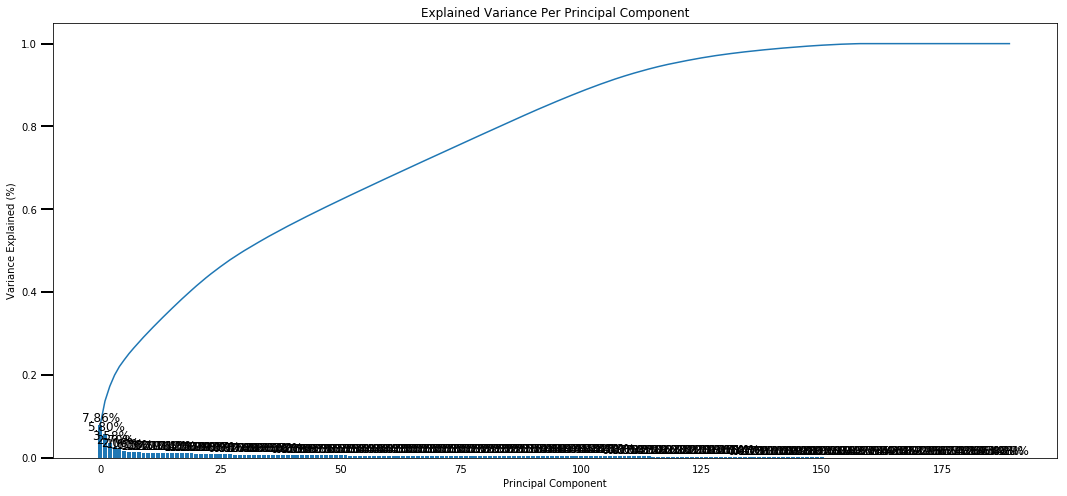

In [42]:
plot_pc(pca)

In [43]:
# Find appropriate number of components to retain
for i in np.arange(15, len(pca.explained_variance_ratio_), 15):
    print('For {} components, explained variance:'.format(i), 
          pca.explained_variance_ratio_[:i].sum())


For 15 components, explained variance: 0.350229417082
For 30 components, explained variance: 0.493129025794
For 45 components, explained variance: 0.588898673672
For 60 components, explained variance: 0.672111825556
For 75 components, explained variance: 0.752314557665
For 90 components, explained variance: 0.831147402882
For 105 components, explained variance: 0.902155611206
For 120 components, explained variance: 0.952229824156
For 135 components, explained variance: 0.980127432818
For 150 components, explained variance: 0.995425404161
For 165 components, explained variance: 1.0
For 180 components, explained variance: 1.0


In [44]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=90)
general_pca_90 = pca.fit_transform(few_missing)

In [125]:
general_pca_90.shape

(797837, 90)

### Discussion 2.2: Perform Dimensionality Reduction

As shown in the graph above, 90 principle components could explain 82% variance and the increase is not that significant after that. So here choose 90 as the number of components for next step of the analysis

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [45]:
# Define function to show the weight of each features by dimension
def show_weight(full_dataset, pca, comp_n, feat_n):
    '''
    Display the weight of each feature in dimension i
    INPUT: 
        full_dataset: dataset
        pca: PCA model fitted with data
        comp_n: index of component
        feat_n: feature number
    OUTPUT: weight of each feature 
    '''
    components = pd.DataFrame(np.round(pca.components_, 4), columns=full_dataset.keys()).iloc[comp_n - 1]
    components.sort_values(ascending=False, inplace=True)
    top2n_components = pd.concat([components.head(feat_n), components.tail(feat_n)])

    # Plot the result
    top2n_components.plot(kind='bar', 
                          title='Top {} weighted features for PCA component {}'.format(feat_n*2, comp_n), 
                          figsize=(12, 6))
    plt.show()
    return components
    

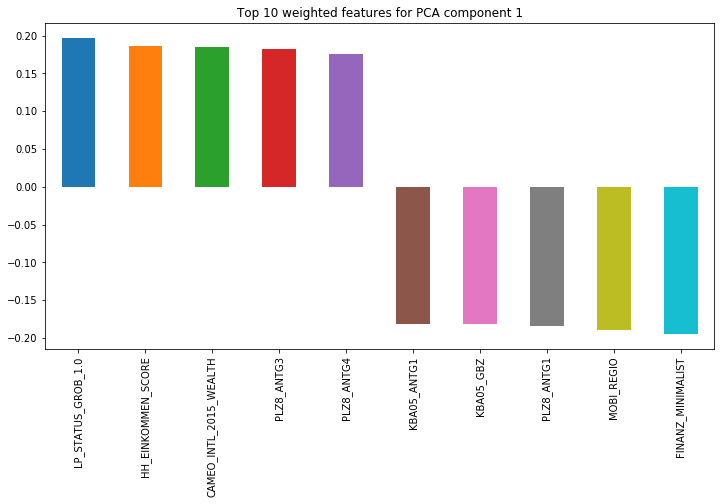

LP_STATUS_GROB_1.0                0.1969
HH_EINKOMMEN_SCORE                0.1860
CAMEO_INTL_2015_WEALTH            0.1850
PLZ8_ANTG3                        0.1824
PLZ8_ANTG4                        0.1759
ORTSGR_KLS9                       0.1555
EWDICHTE                          0.1542
FINANZ_HAUSBAUER                  0.1491
KBA05_ANTG4                       0.1300
LP_STATUS_FEIN_1.0                0.1260
PLZ8_ANTG2                        0.1258
FINANZ_SPARER                     0.1201
LP_STATUS_FEIN_2.0                0.1186
KBA05_ANTG3                       0.1179
FINANZTYP_1.0                     0.1170
ANZ_HAUSHALTE_AKTIV               0.1168
CAMEO_DEUG_2015_9                 0.1145
ARBEIT                            0.1135
RELAT_AB                          0.1079
PRAEGENDE_JUGENDJAHRE_MOVEMENT    0.1046
LP_FAMILIE_GROB_1.0               0.0913
LP_FAMILIE_FEIN_1.0               0.0913
CAMEO_DEUG_2015_8                 0.0904
SEMIO_PFLICHT                     0.0875
SEMIO_REL       

In [46]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.

components1 = show_weight(few_missing, pca, 1, 5)
components1

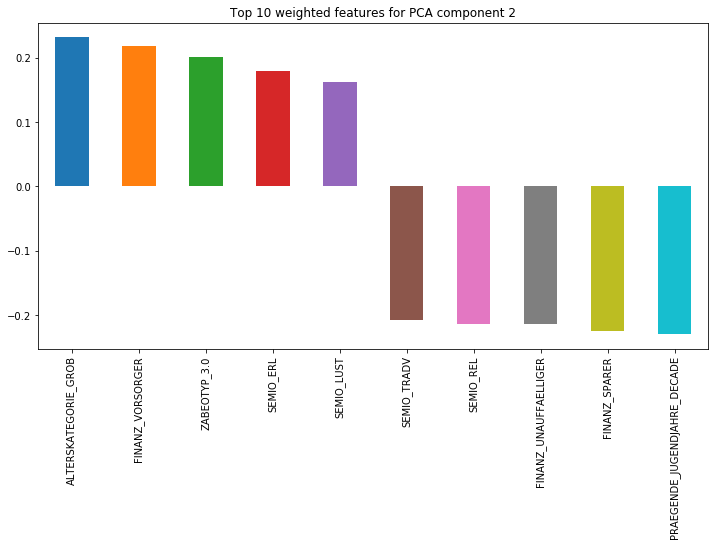

ALTERSKATEGORIE_GROB            0.2316
FINANZ_VORSORGER                0.2174
ZABEOTYP_3.0                    0.2005
SEMIO_ERL                       0.1800
SEMIO_LUST                      0.1626
RETOURTYP_BK_S                  0.1551
W_KEIT_KIND_HH                  0.1248
CJT_GESAMTTYP_2.0               0.1079
LP_STATUS_FEIN_1.0              0.0996
FINANZTYP_5.0                   0.0981
FINANZ_HAUSBAUER                0.0906
FINANZTYP_2.0                   0.0902
FINANZ_MINIMALIST               0.0832
SHOPPER_TYP_3.0                 0.0739
SEMIO_KRIT                      0.0739
CJT_GESAMTTYP_1.0               0.0705
LP_FAMILIE_GROB_1.0             0.0700
LP_FAMILIE_FEIN_1.0             0.0700
PLZ8_ANTG3                      0.0684
EWDICHTE                        0.0675
FINANZTYP_6.0                   0.0674
PLZ8_ANTG4                      0.0668
ORTSGR_KLS9                     0.0664
NATIONALITAET_KZ_1.0            0.0656
CAMEO_INTL_2015_WEALTH          0.0629
SEMIO_KAEM               

In [47]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

components2 = show_weight(few_missing, pca, 2, 5)
components2

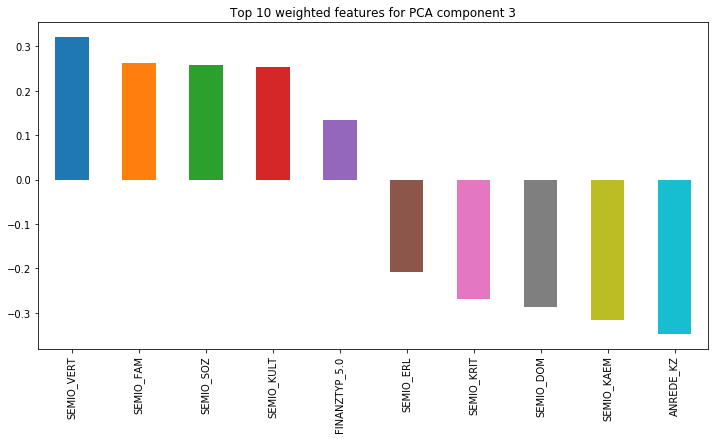

SEMIO_VERT                        0.3207
SEMIO_FAM                         0.2615
SEMIO_SOZ                         0.2576
SEMIO_KULT                        0.2537
FINANZTYP_5.0                     0.1332
FINANZ_MINIMALIST                 0.1306
SHOPPER_TYP_0.0                   0.1246
ZABEOTYP_1.0                      0.1150
SEMIO_REL                         0.1137
SEMIO_MAT                         0.0877
RETOURTYP_BK_S                    0.0762
GREEN_AVANTGARDE                  0.0685
W_KEIT_KIND_HH                    0.0635
ORTSGR_KLS9                       0.0599
EWDICHTE                          0.0594
ZABEOTYP_6.0                      0.0501
FINANZ_VORSORGER                  0.0490
LP_STATUS_GROB_5.0                0.0483
LP_STATUS_FEIN_10.0               0.0483
PLZ8_ANTG4                        0.0469
PLZ8_ANTG3                        0.0465
LP_STATUS_FEIN_1.0                0.0446
LP_STATUS_FEIN_3.0                0.0424
SHOPPER_TYP_1.0                   0.0353
RELAT_AB        

In [48]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

components3 = show_weight(few_missing, pca, 3, 5)
components3


### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

From the analysis above, it shows detail of how each feature distibute within each dimension. Analyse the first three dimensions along with top 10 features in details.

#### Dimension 1
- In the first dimension, it's positively affected by  
    - HH_EINKOMMEN_SCORE                0.2061 Estimated household net income
    - LP_STATUS_GROB_1.0                0.1957 Social status, rough scale
    - FINANZ_HAUSBAUER                  0.1948 Financial typology
    - CAMEO_INTL_2015_WEALTH            0.1875 Wealth / Life Stage Typology
    - PLZ8_ANTG3                        0.1869 Number of 6-10 family houses in the PLZ8 region
- In the first dimension, it's positively affected by  
    - LP_STATUS_GROB_4.0               -0.1358 Social status, rough scale
    - KONSUMNAEHE                      -0.1558 Distance from building to point of sale (PoS)
    - PLZ8_ANTG1                       -0.1711 Number of 1-2 family houses in the PLZ8 region
    - FINANZ_MINIMALIST                -0.1719 Financial typology
    - KBA05_GBZ                        -0.1956 Number of buildings in the microcell


#### Dimension 2
- In the second dimension, it's positively affected by   
    - FINANZ_VORSORGER                0.2502 Financial typology
    - ALTERSKATEGORIE_GROB            0.2262 Estimated age based on given name analysis
    - ZABEOTYP_3.0                    0.1761 Energy consumption typology
    - FINANZ_MINIMALIST               0.1640 Financial typology
    - SEMIO_ERL                       0.1452 Personality typology
- In the second dimension, it's positively affected by  
    - SEMIO_REL                      -0.2126 Personality typology
    - PRAEGENDE_JUGENDJAHRE_DECADE   -0.2285 Dominating movement of person's youth
    - FINANZ_ANLEGER                 -0.2336 Financial typology
    - FINANZ_UNAUFFAELLIGER          -0.2421 Financial typology
    - FINANZ_SPARER                  -0.2710 Financial typology

#### Dimension 3
- In the third dimension, it's positively affected by   
    - SEMIO_VERT                      0.3085 Personality typology
    - SEMIO_KULT                      0.2806 Personality typology
    - SEMIO_FAM                       0.2768 Personality typology
    - SEMIO_SOZ                       0.2562 Personality typology
    - SEMIO_MAT                       0.1358 Personality typology
- In the third dimension, it's positively affected by  
    - SEMIO_ERL                      -0.2355 Personality typology
    - SEMIO_KRIT                     -0.2874 Personality typology
    - SEMIO_DOM                      -0.3015 Personality typology
    - SEMIO_KAEM                     -0.3190 Personality typology
    - ANREDE_KZ                      -0.3508 Personality typology



## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [49]:
# Over a number of different cluster counts...


    # run k-means clustering on the data and...
    
    
    # compute the average within-cluster distances.
    
    

In [50]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
def get_kmeans_score(data, center):
    '''
    return the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    # instantiate kmeans
    kmeans = KMeans(n_clusters=center)
    
    # Then fit the model to you data using the fit mothod
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score

In [51]:
scores = []
centers = list(range(10, 30, 2))

start_time = time.time()

for center in centers:
    print('Fitting k = {} '.format(center))
    scores.append(get_kmeans_score(general_pca_90, center))

print("--- Run time: %s mins ---" % np.round(((time.time() - start_time)/60),2))

Fitting k = 10 
Fitting k = 12 
Fitting k = 14 
Fitting k = 16 
Fitting k = 18 
Fitting k = 20 
Fitting k = 22 
Fitting k = 24 
Fitting k = 26 
Fitting k = 28 
--- Run time: 78.82 mins ---


Text(0.5,1,'SSE vs. K')

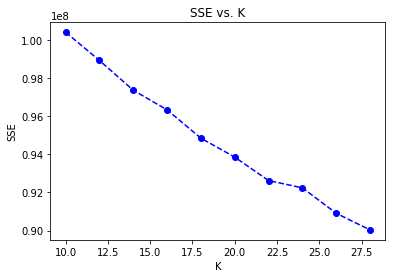

In [52]:
# Plot the SSE value to decide the K value
plt.plot(centers, scores, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('SSE')
plt.title('SSE vs. K')


In [71]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters=16)
model = kmeans.fit(general_pca_90)

### Discussion 3.1: Apply Clustering to General Population

Try different K value range from 10 to 30, store SSE and compare to decide the final K value. As shown in plot above, there's no clear elbow, here choose 16 as cluster number since there's a relatively dramatice decrease at that point.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [54]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')
customers.shape

(191652, 85)

In [55]:
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [56]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
few_missing_customer = clean_data(customers)
few_missing_customer.shape

Replace the missing value with NaN
Remove selected columns and rows
Select, re-encode, and engineer column values
Map the decade
Map the movement
Drop the original column
Map the wealth level
Map the life stage
Drop the original column
Drop the rest of mixed type columns


(141708, 189)

In [57]:
# In order to fit the customer data using model fitted on general data, check the feature number of two data set
list(set(few_missing) - set(few_missing_customer.columns))

['GEBAEUDETYP_5.0']

In [58]:
# In order to fit customer data with model which fitted on general data, need to make up the missing data to make the
# column number same
customer_adjusted = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')
display(customer_adjusted.shape)
customer_adjusted = pd.concat([customer_adjusted, customer_adjusted.iloc[-1:]], ignore_index=True)
display(customer_adjusted.shape)

(191652, 85)

(191653, 85)

In [59]:
# Add in 'GEBAEUDETYP_5.0' to get the column
customer_adjusted.loc[191652, 'GEBAEUDETYP'] = 5.0
few_missing_customer_adjuested = clean_data(customer_adjusted)
few_missing_customer_adjuested.shape

Replace the missing value with NaN
Remove selected columns and rows
Select, re-encode, and engineer column values
Map the decade
Map the movement
Drop the original column
Map the wealth level
Map the life stage
Drop the original column
Drop the rest of mixed type columns


(141709, 190)

In [60]:
few_missing_customer_adjuested.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFESTAGE
0,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,1,1.0,...,0,0,0,0,0,0,1,0,1,3
1,4.0,2.0,5.0,1.0,5.0,1.0,4.0,4.0,1,2.0,...,0,0,0,0,0,0,1,0,3,4
2,4.0,1.0,5.0,1.0,5.0,2.0,1.0,2.0,0,2.0,...,0,0,0,0,0,0,0,1,2,4
3,3.0,1.0,3.0,1.0,4.0,4.0,5.0,2.0,0,3.0,...,0,0,0,0,0,0,3,1,4,1
4,3.0,1.0,5.0,1.0,5.0,1.0,2.0,3.0,1,3.0,...,0,0,0,0,0,0,1,0,3,4


In [61]:
# In order to fit the customer data using model fitted on general data, check the feature number of two data set
list(set(few_missing) - set(few_missing_customer_adjuested.columns))

[]

In [121]:
# Normalize the customer data
# scaler = StandardScaler()
few_missing_customer_adjuested[few_missing_customer_adjuested.columns] = scaler.transform(few_missing_customer_adjuested[few_missing_customer_adjuested.columns].as_matrix())


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [126]:
few_missing_customer_adjuested.shape

(141709, 190)

In [63]:
# Transform customer data using fitted model from previous steps
customers_pca=pca.transform(few_missing_customer_adjuested)
customers_pca.shape

(141709, 90)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [72]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# Store the prediction for both general and customer dataset
general_predict = pd.DataFrame(np.array(model.predict(general_pca_90)), columns=['Prediction'])
customer_predict = pd.DataFrame(np.array(model.predict(customers_pca)), columns=['Prediction'])

# Account for rows with many missings which were dropped in the previous steps
general_missing = np.full((many_missing.shape[0],), -1)
customer_missing = np.full((customers.shape[0] - few_missing_customer_adjuested.shape[0],), -1)

# Put few_missing and many_missing together
general_all = np.concatenate([general_predict['Prediction'], general_missing])
customer_all = np.concatenate([customer_predict['Prediction'], customer_missing])

# Count the cluster number
general_cnt = pd.Series(general_all).value_counts().sort_index()
customer_cnt = pd.Series(customer_all).value_counts().sort_index()

display(general_cnt)
display(customer_cnt)

-1     93384
 0     70685
 1     32827
 2     57707
 3     48242
 4     67705
 5     56369
 6     44322
 7     31423
 8     45946
 9     26265
 10    98932
 11    41182
 12    14937
 13    80360
 14    45777
 15    35158
dtype: int64

-1     49943
 0      7340
 1     14924
 2      1241
 3     37057
 4      8089
 5       751
 6     13440
 7      4290
 8      5082
 9      1197
 10    26700
 11    10744
 12     3426
 13     1040
 14     1518
 15     4870
dtype: int64

In [73]:
general_prop = pd.DataFrame((general_cnt/general_cnt.sum()), columns=['General']).reset_index()
# general_prop['Cluster']=general_prop.index.values
# general_prop['DateSet']='General'
general_prop.set_index('index', inplace=True)
display(general_prop)

customer_prop = pd.DataFrame((customer_cnt/customer_cnt.sum()), columns=['Customer']).reset_index()
# customer_prop['Cluster']=customer_prop.index.values
# customer_prop['DataSet']='Customer'
customer_prop.set_index('index', inplace=True)
display(customer_prop)


,General
index,
-1,0.104782
0,0.079313
1,0.036834
2,0.064750
3,0.054130
4,0.075969
5,0.063249
6,0.049732
7,0.035258


,Customer
index,
-1,0.260592
0,0.038299
1,0.077870
2,0.006475
3,0.193356
4,0.042207
5,0.003919
6,0.070127
7,0.022384


In [74]:
# Put general and customer prediction together to generate comparison plot
all_prop = pd.concat([general_prop, customer_prop],axis=1).reset_index()
all_prop
# all_prop.rename(columns = {'index':'Cluster'})

,index,General,Customer
0,-1,0.104782,0.260592
1,0,0.079313,0.038299
2,1,0.036834,0.077870
3,2,0.064750,0.006475
4,3,0.054130,0.193356
5,4,0.075969,0.042207
6,5,0.063249,0.003919
7,6,0.049732,0.070127
8,7,0.035258,0.022384
9,8,0.051554,0.026517


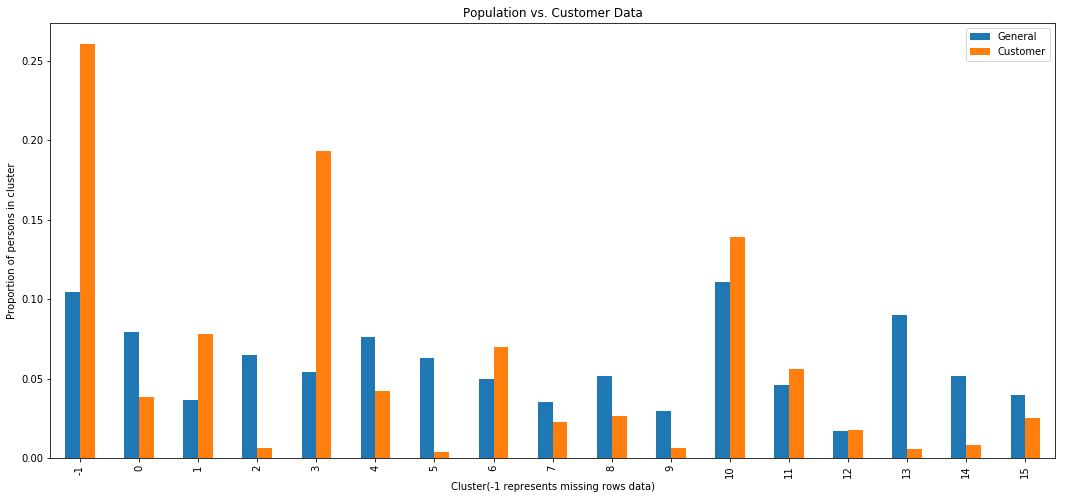

In [75]:
all_prop.plot(x = 'index', y = ['General','Customer'], kind = 'bar', figsize = (18,8 ))
plt.title('Population vs. Customer Data')
plt.xlabel('Cluster(-1 represents missing rows data)')
plt.ylabel('Proportion of persons in cluster')
plt.show()

In [157]:
# Investigate top cemponents of cluster 1
cluster1_components = pd.Series(kmeans.cluster_centers_[1])
cluster1_components.sort_values(ascending=False, inplace=True)
cluster1_components.head(5)

6     4.919873
12    1.710247
3     1.635983
8     1.496560
23    1.494504
dtype: float64

In [135]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# Cluster 1, 3, 6, 10, 11
# To get the detail of cluster, transfer cluster back to analyze the principle component

cluster1 = scaler.inverse_transform(pca.inverse_transform(customers_pca))[customer_predict.Prediction==3]
cluster1_features = pd.DataFrame(data = np.round(cluster1), columns= few_missing.columns)
cluster1_features.headb()


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFESTAGE
0,2.0,-1.0,1.0,-1.0,1.0,-1.0,-0.0,-0.0,2.0,-2.0,...,-0.0,-0.0,-1.0,0.0,0.0,-0.0,-1.0,-2.0,-2.0,0.0
1,0.0,-1.0,2.0,-2.0,2.0,-1.0,-1.0,-0.0,2.0,-1.0,...,0.0,-1.0,-0.0,1.0,0.0,-1.0,-1.0,-2.0,-1.0,0.0
2,1.0,-1.0,1.0,-1.0,1.0,-2.0,-0.0,-0.0,2.0,-1.0,...,-0.0,-1.0,0.0,0.0,-0.0,0.0,-1.0,-2.0,-1.0,1.0
3,0.0,-1.0,1.0,-1.0,1.0,-1.0,0.0,-1.0,2.0,1.0,...,-0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-2.0,-1.0,1.0
4,0.0,-1.0,1.0,-1.0,1.0,-1.0,-0.0,-0.0,2.0,-2.0,...,0.0,-0.0,-1.0,-0.0,0.0,0.0,-1.0,-2.0,-2.0,1.0


In [137]:
cluster1_general = scaler.inverse_transform(pca.inverse_transform(general_pca_90))[general_predict.Prediction==3]
cluster1_general_features = pd.DataFrame(data = np.round(cluster1_general), columns= few_missing.columns)
cluster1_general_features.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFESTAGE
0,0.0,-1.0,2.0,-1.0,1.0,-1.0,-0.0,-0.0,2.0,0.0,...,-0.0,-0.0,0.0,-0.0,-0.0,-1.0,-1.0,-2.0,-1.0,-1.0
1,0.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,2.0,0.0,...,-0.0,0.0,0.0,-0.0,-1.0,0.0,-1.0,-2.0,-2.0,1.0
2,-1.0,-1.0,1.0,-0.0,-0.0,-0.0,-0.0,-1.0,2.0,0.0,...,0.0,0.0,-0.0,-1.0,-0.0,1.0,0.0,-2.0,-1.0,1.0
3,0.0,-1.0,1.0,-0.0,1.0,-1.0,-1.0,-1.0,2.0,0.0,...,-0.0,0.0,0.0,-0.0,-1.0,0.0,-0.0,-2.0,1.0,0.0
4,0.0,-0.0,1.0,-1.0,0.0,-0.0,-1.0,-1.0,2.0,-1.0,...,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-2.0,-1.0,1.0


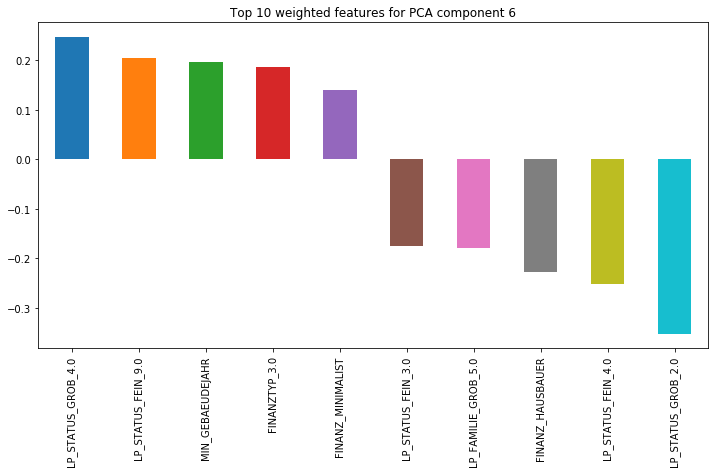

LP_STATUS_GROB_4.0           0.2472
LP_STATUS_FEIN_9.0           0.2057
MIN_GEBAEUDEJAHR             0.1959
FINANZTYP_3.0                0.1860
FINANZ_MINIMALIST            0.1408
LP_STATUS_FEIN_8.0           0.1348
LP_FAMILIE_GROB_4.0          0.1344
LP_FAMILIE_FEIN_1.0          0.1148
LP_FAMILIE_GROB_1.0          0.1148
CAMEO_DEUG_2015_9            0.1133
GFK_URLAUBERTYP_2.0          0.1102
LP_FAMILIE_FEIN_7.0          0.1078
LP_STATUS_FEIN_1.0           0.0995
LP_STATUS_FEIN_10.0          0.0976
LP_STATUS_GROB_5.0           0.0976
ZABEOTYP_2.0                 0.0898
CAMEO_DEU_2015_3A            0.0843
ORTSGR_KLS9                  0.0828
FINANZTYP_6.0                0.0816
SEMIO_KRIT                   0.0807
GEBAEUDETYP_1.0              0.0804
CAMEO_DEUG_2015_2            0.0744
LP_STATUS_GROB_1.0           0.0711
CAMEO_DEU_2015_9B            0.0708
EWDICHTE                     0.0689
LP_FAMILIE_FEIN_6.0          0.0675
CAMEO_DEU_2015_9C            0.0651
SEMIO_KAEM                  

In [156]:
# Chenck top features in first component for customer data
show_weight(cluster1_features, pca, 6, 5)

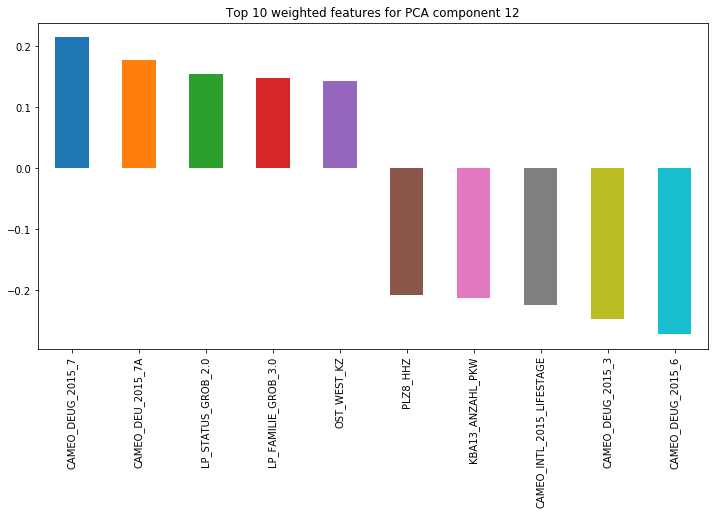

CAMEO_DEUG_2015_7                 0.2150
CAMEO_DEU_2015_7A                 0.1784
LP_STATUS_GROB_2.0                0.1546
LP_FAMILIE_GROB_3.0               0.1485
OST_WEST_KZ                       0.1438
CAMEO_DEUG_2015_2                 0.1417
LP_STATUS_FEIN_4.0                0.1316
LP_FAMILIE_FEIN_2.0               0.1312
LP_FAMILIE_GROB_2.0               0.1312
CAMEO_DEU_2015_7B                 0.1153
LP_FAMILIE_FEIN_4.0               0.0993
CAMEO_DEUG_2015_4                 0.0963
LP_FAMILIE_FEIN_5.0               0.0917
FINANZTYP_6.0                     0.0907
NATIONALITAET_KZ_1.0              0.0904
CAMEO_DEU_2015_2B                 0.0798
GREEN_AVANTGARDE                  0.0780
CAMEO_DEU_2015_4A                 0.0780
CAMEO_DEUG_2015_5                 0.0733
LP_STATUS_FEIN_10.0               0.0687
LP_STATUS_GROB_5.0                0.0687
CAMEO_DEU_2015_2D                 0.0686
LP_FAMILIE_GROB_4.0               0.0676
CAMEO_DEU_2015_2C                 0.0669
KONSUMNAEHE     

In [155]:
# Chenck top features in first component for customer data
show_weight(cluster1_features, pca, 12, 5)

In [149]:
cluster2_components = pd.Series(kmeans.cluster_centers_[2])
cluster2_components.sort_values(ascending=False, inplace=True)
cluster2_components.head(5)

29    0.395001
33    0.375588
32    0.360562
20    0.337942
27    0.289447
dtype: float64

In [138]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# Cluster 0, 2, 4, 5, 7, 8, 9, 12, 13, 14,15
cluster2 = scaler.inverse_transform(pca.inverse_transform(customers_pca))[customer_predict.Prediction==2]
cluster2_features = pd.DataFrame(data = np.round(cluster2), columns= few_missing.columns)
cluster2_features.head()


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFESTAGE
0,-0.0,1.0,-1.0,1.0,-0.0,1.0,1.0,0.0,1.0,-1.0,...,-0.0,-1.0,-0.0,-0.0,0.0,-0.0,1.0,-1.0,-1.0,1.0
1,-0.0,1.0,-1.0,1.0,-0.0,1.0,1.0,-0.0,1.0,0.0,...,-0.0,-1.0,0.0,-0.0,-0.0,-0.0,1.0,-1.0,-1.0,1.0
2,-2.0,1.0,0.0,1.0,-1.0,1.0,1.0,-1.0,-0.0,1.0,...,0.0,-0.0,-0.0,0.0,-0.0,0.0,1.0,0.0,-1.0,-1.0
3,-2.0,0.0,-0.0,1.0,-0.0,1.0,1.0,-0.0,1.0,1.0,...,-0.0,-0.0,-1.0,-0.0,0.0,0.0,1.0,-1.0,-1.0,2.0
4,-1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,0.0,-1.0,0.0,...,-0.0,-1.0,-1.0,1.0,-0.0,0.0,1.0,1.0,-0.0,-1.0


In [139]:
cluster2_general = scaler.inverse_transform(pca.inverse_transform(general_pca_90))[general_predict.Prediction==2]
cluster2_general_features = pd.DataFrame(data = np.round(cluster2_general), columns= few_missing.columns)
cluster2_general_features.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFESTAGE
0,-2.0,1.0,0.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,0.0,...,0.0,-0.0,-1.0,0.0,-0.0,-0.0,1.0,1.0,-1.0,1.0
1,0.0,1.0,-1.0,1.0,-0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,-0.0,-0.0,-1.0,-0.0,0.0,1.0,-1.0,-1.0,1.0
2,0.0,1.0,-1.0,1.0,-1.0,1.0,2.0,-1.0,-1.0,0.0,...,1.0,0.0,-0.0,-0.0,-0.0,0.0,1.0,1.0,1.0,0.0
3,-2.0,1.0,-1.0,1.0,-1.0,2.0,1.0,1.0,-1.0,1.0,...,-0.0,0.0,4.0,0.0,0.0,-0.0,1.0,1.0,1.0,-1.0
4,-1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,0.0,-0.0,0.0,...,-0.0,-1.0,0.0,0.0,-0.0,-1.0,1.0,0.0,-1.0,1.0


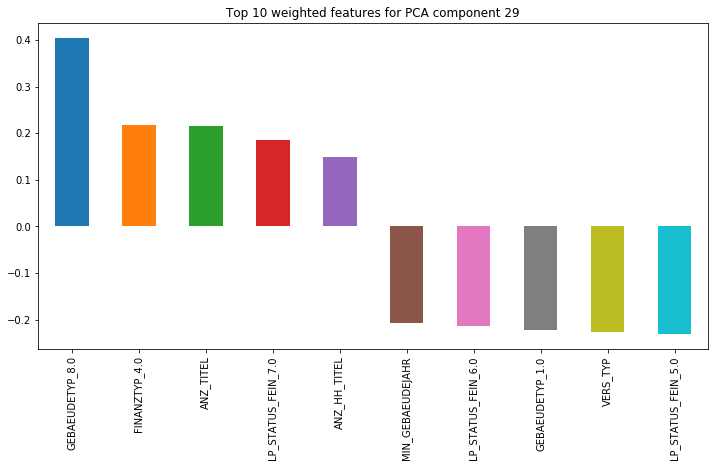

GEBAEUDETYP_8.0         0.4042
FINANZTYP_4.0           0.2168
ANZ_TITEL               0.2144
LP_STATUS_FEIN_7.0      0.1854
ANZ_HH_TITEL            0.1492
CJT_GESAMTTYP_4.0       0.1468
KBA05_ANTG2             0.1406
SEMIO_MAT               0.1260
ZABEOTYP_4.0            0.1135
SEMIO_LUST              0.1053
HH_EINKOMMEN_SCORE      0.0843
LP_FAMILIE_FEIN_6.0     0.0827
CAMEO_DEU_2015_2D       0.0787
LP_FAMILIE_FEIN_7.0     0.0727
SHOPPER_TYP_3.0         0.0718
NATIONALITAET_KZ_1.0    0.0706
GFK_URLAUBERTYP_1.0     0.0690
ALTERSKATEGORIE_GROB    0.0686
CAMEO_DEU_2015_3C       0.0677
MOBI_REGIO              0.0664
ONLINE_AFFINITAET       0.0656
GFK_URLAUBERTYP_3.0     0.0654
GFK_URLAUBERTYP_12.0    0.0625
LP_STATUS_FEIN_1.0      0.0612
KBA05_ANTG1             0.0572
LP_STATUS_FEIN_8.0      0.0568
CAMEO_DEU_2015_9E       0.0568
SEMIO_ERL               0.0542
LP_STATUS_FEIN_4.0      0.0542
CAMEO_DEUG_2015_2       0.0513
                         ...  
RELAT_AB               -0.0433
RETOURTY

In [152]:
# Chenck top features in top component for customer data
show_weight(cluster2_features, pca, 29, 5)

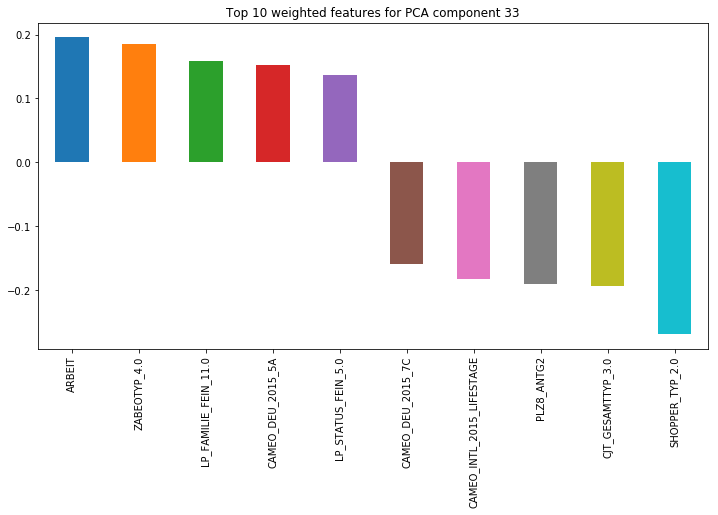

ARBEIT                       0.1957
ZABEOTYP_4.0                 0.1855
LP_FAMILIE_FEIN_11.0         0.1588
CAMEO_DEU_2015_5A            0.1518
LP_STATUS_FEIN_5.0           0.1361
SHOPPER_TYP_3.0              0.1343
RELAT_AB                     0.1341
LP_STATUS_FEIN_1.0           0.1324
KONSUMNAEHE                  0.1308
SHOPPER_TYP_1.0              0.1302
GEBAEUDETYP_RASTER           0.1300
PLZ8_ANTG1                   0.1297
PLZ8_GBZ                     0.1291
CAMEO_DEU_2015_7A            0.1283
ORTSGR_KLS9                  0.1173
CJT_GESAMTTYP_6.0            0.1097
GFK_URLAUBERTYP_9.0          0.0975
GEBAEUDETYP_8.0              0.0951
FINANZTYP_4.0                0.0914
LP_STATUS_GROB_3.0           0.0904
CJT_GESAMTTYP_4.0            0.0898
CAMEO_DEU_2015_3D            0.0894
PLZ8_HHZ                     0.0830
LP_STATUS_FEIN_6.0           0.0752
OST_WEST_KZ                  0.0749
FINANZTYP_5.0                0.0740
CAMEO_DEU_2015_6A            0.0727
KBA05_ANTG1                 

In [154]:
# Chenck top features in first component for customer data
show_weight(cluster2_features, pca, 33, 5)

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)  

#### From the graph above we can see
- Cluster that is overrepresented in the customer data compared to the general population:  
    Cluster 1, 3, 6, 10, 11  
    Choose cluster 1, and analyze the top features of top 2 components:  
    
    - LP_STATUS_GROB_4.0           0.2472
    - LP_STATUS_FEIN_9.0           0.2057
    - MIN_GEBAEUDEJAHR             0.1959
    - FINANZTYP_3.0                0.1860
    - FINANZ_MINIMALIST            0.1408
    - LP_STATUS_FEIN_3.0          -0.1747
    - LP_FAMILIE_GROB_5.0         -0.1788
    - FINANZ_HAUSBAUER            -0.2281
    - LP_STATUS_FEIN_4.0          -0.2526
    - LP_STATUS_GROB_2.0          -0.3518

    - CAMEO_DEUG_2015_7                 0.2150
    - CAMEO_DEU_2015_7A                 0.1784
    - LP_STATUS_GROB_2.0                0.1546
    - LP_FAMILIE_GROB_3.0               0.1485
    - OST_WEST_KZ                       0.1438
    - PLZ8_HHZ                         -0.2085
    - KBA13_ANZAHL_PKW                 -0.2131
    - CAMEO_INTL_2015_LIFESTAGE        -0.2241
    - CAMEO_DEUG_2015_3                -0.2468
    - CAMEO_DEUG_2015_6                -0.2718
    
    In this case, there are more people who are houseowners (maps to 8-9 in fine scale), top earners (maps to 10 in fine scale), villagers, aspiring low-income earners, average earners (maps to 3-5 in fine scale) or people with unknown or very low financial status. Also, there are more people who is in lower middleclass, established middleclass, low-consumption middleclass, more Journeymen who are more interested in mail-order company.
    
    
- Cluster that is underoverrepresented in the customer data compared to the general population:  
    Cluster 0, 2, 4, 5, 7, 8, 9, 12, 13, 14,15  
    Choose cluster 2, and analyze the top features of top 2 components:  
    
    - GEBAEUDETYP_8.0         0.4042  
    - FINANZTYP_4.0           0.2168  
    - ANZ_TITEL               0.2144  
    - LP_STATUS_FEIN_7.0      0.1854  
    - ANZ_HH_TITEL            0.1492  
    - MIN_GEBAEUDEJAHR       -0.2065  
    - LP_STATUS_FEIN_6.0     -0.2133  
    - GEBAEUDETYP_1.0        -0.2218  
    - VERS_TYP               -0.2270  
    - LP_STATUS_FEIN_5.0     -0.2316  

    - ARBEIT                       0.1957  
    - ZABEOTYP_4.0                 0.1855  
    - LP_FAMILIE_FEIN_11.0         0.1588  
    - CAMEO_DEU_2015_5A            0.1518  
    - LP_STATUS_FEIN_5.0           0.1361  
    - CAMEO_DEU_2015_7C           -0.1587  
    - CAMEO_INTL_2015_LIFESTAGE   -0.1830  
    - PLZ8_ANTG2                  -0.1899  
    - CJT_GESAMTTYP_3.0           -0.1942
    - SHOPPER_TYP_2.0             -0.2683
    
    In this case, there are more people who just be prepared for financing, people who are independent workers, minimalistic high-income earners, people who are price driven, family with multi-generational household, single parent with child of full age, Younger Employees.
    



> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.